### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. It may also be pruned completely if using Google Colab, so watch out for this. Searching for "nbgrader" when opening the notebook in a text editor should take you to the important metadata entries.
7. Although we will try our very best to avoid this, it may happen that bugs are found after an assignment is released, and that we will push an updated version of the assignment to GitHub. If this happens, it is important that you update to the new version, while making sure the notebook metadata is properly updated as well. The safest way to make sure nothing gets messed up is to start from scratch on a clean updated version of the notebook, copy/pasting your code from the cells of the previous version into the cells of the new version.
8. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
9. Although not forced to work exclusively in the course Docker environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

Failing to meet any of these requirements might lead to either a subtraction of POEs (at best) or a request for resubmission (at worst).

We advise you the following steps before submission for ensuring that requirements 1, 2, and 3 are always met: **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). This might require a bit of time, so plan ahead for this (and possibly use Google Cloud's GPU in HA1 and HA2 for this step). Finally press the "Save and Checkout" button before handing in, to make sure that all your changes are saved to this .ipynb file.

### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [2]:
nb_fname = "HA1.ipynb"

### Fill in group number and member names:

In [3]:
GROUP = "15"
NAME1 = "Tobias Karlsson"
NAME2 = "Pavan Sreenivasa Bharadwaj"

### Check Python version

In [4]:
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','7'), "You are not running Python 3.7. Make sure to run Python through the course Docker environment, or alternatively in the provided Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [5]:
import os
nb_dirname = os.path.abspath('')
assert nb_dirname != '/workspace', \
    '[ERROR] The notebook server appears to have been started via Docker, at the same directory as the assignment. Make sure to start it at least one level above the assignment.'
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in ['IHA1', 'IHA2', 'HA1', 'HA2', 'HA3'], \
    '[ERROR] The notebook appears to have been moved from its original directory'

### Verify correct nb_fname

In [6]:
from IPython.display import display, HTML
try:
    display(HTML(r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(nb_fname=nb_fname)))
except NameError:
    assert False, 'Make sure to fill in the nb_fname variable above!'

### Verify that your notebook is up-to-date and not corrupted in any way

In [7]:
import sys
sys.path.append('..')
from ha_utils import check_notebook_uptodate_and_not_corrupted
check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

[SUCCESS] No major notebook mismatch found when comparing to latest GitHub version. (There might be minor updates, but even that is the case, submitting your work based on this notebook version would be acceptable.)


# HA1 - Cats and dogs

<img src="http://lghttp.32478.nexcesscdn.net/80E972/organiclifestylemagazine/wp-content/uploads/2015/10/Cats-and-Dogs.jpg" alt="Cats and dogs" style="width: 5000px;"/>

For this home assignment, we'll use the Kaggle dataset for the [Dogs vs. Cats competition](https://www.kaggle.com/c/dogs-vs-cats). It is comprised of 25k colored images of dogs and cats. Our goal with this dataset will be to create a classifier that can tell us if the input image is of a cat or a dog.

As a way of helping you speed up the training process, each group gets access to an instance in Google Cloud with a K80 GPU. Take a look at the [Instructions folder](https://github.com/JulianoLagana/deep-machine-learning/blob/master/Instructions/03_using_google_cloud.md) to understand how to connect to this instance and use our tools there. You're free to use this limited resource as you see fit, but if you spend all your credits, you'll need a late day to obtain more (and you can only do this once).

In order to make the most out of your GPU hours, first try solving the initial part of this notebook (tasks 0-3) in your own computer (these tasks can be solved only on the CPU), and leave most of the available hours for solving tasks 4-5, and refining your best model further (and, if you have the spare hours, experiment a bit!).

Requirements:
- Whenever we ask you to plot anything, be sure to add a title and label the axes. If you're plotting more than one curve in the same plot, also add a legend.
- When we ask you to train an architecture, train it for a reasonable number of epochs. "Reasonable" here means you should be fairly confident that training for a higher number of epochs wouldn't impact your conclusions regarding the model's performance.


Hints:
- If you get errors saying you've exhausted the GPU resources, well, then you exhausted the GPU resources. However, sometimes that's because Pytorch didn't release a part of the GPU's memory. If you think your CNN should fit in your memory during training, try restarting the kernel and directly training only that architecture.
- Every group has enough credits on google cloud to complete this assignment. However, this statement assumes you'll use your resources judiciously (e.g. always try the code first in your machine and make sure everything works properly before starting your instances) and **won't forget to stop your instance after using it,**  otherwise you might run out of credits.
- Before starting, take a look at the images we'll be using. This is a hard task, don't get discouraged if your first models perform poorly (several participants in the original competition didn't achieve an accuracy higher than 60%).
- Solving the [computer labs](https://github.com/JulianoLagana/deep-machine-learning/tree/master/computer-labs) is a good way to get prepared for this assignment.

---
## 0. Imports

In the following cell, add all the imports you'll use in this assignment.

In [1]:
# YOUR CODE HERE
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.models as models

---
## 1. Loading the data and preprocessing

The first step is to head to the [Kaggle website for the cats and dogs competition](https://www.kaggle.com/c/dogs-vs-cats) and download the data from there. You should download both the test and train folders together in one zip file (by clicking the download all button). The split ratio between training and validation has not been made, you'll need to do it yourself. The `test.zip` file contains unlabeled data, so that participants in the contest are not able to train on this set.

Downloading the data to the Google Cloud instance can be a bit tricky. There are a few ways to do it:

 - Using `scp` with the `gcloud` CLI. Download the `dogs-vs-cats.zip` to your local computer and then copy it from there to your cloud instance with the command:
 ```
 # Note: This assumes you named your VM instance (gpu-instance)
 gcloud compute scp  <path_to_local_file>/dogs-vs-cats.zip dml-host@gpu-instance:~/deep-machine-learning/home-assignments/HA1/
 ```
 `scp` uses the same credentials as `ssh`, which `gcloud` handles for you. The first time you `ssh` directly into `dml-host` you have to set a password for your `ssh` keys
 - Using the Kaggle CLI. We have it installed in the docker image, and you can read about it [here](https://github.com/Kaggle/kaggle-api) 

For this assignment you should use [data generators](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) to load the images to your CPU/GPU memory. Because of this, your folder structure for the data should conform to the folder structure expected by the data generators (i.e. the samples should be separated into one folder for each class). Furthermore, we ask you to first start with a smaller subset of the data (1/5 of the number of samples), in order to test different models faster.

This means that you should create a folder structure that resembles the following (obviously, the folder names are up to you):


         small_train             small_val                train                   val
              |                      |                      |                      |
              |                      |                      |                      |
        -------------          -------------          -------------          -------------
        |           |          |           |          |           |          |           |
        |           |          |           |          |           |          |           |
      Cats        Dogs       Cats        Dogs       Cats        Dogs       Cats        Dogs

The `small_train` and `small_val` folders have the training and validation samples for your smaller subset of the data, while the `train` and `val` folders contain all the samples you extracted from Kaggle's `train.zip`. We provide you a notebook that shows how to achieve this (`create_project_notebook_structure.ipynb`), starting from the original `dogs-vs-cats.zip` file that you download from Kaggle. If you do use that notebook, we encourage you to understand how each step is being done, so you can generalize this knowledge to new datasets you'll encounter.

We advise you to use 30% of the data as validation data in the smaller dataset. However, for the larger dataset, you should decide how to split between training and validation. Please specify your splits in the following cells.

For the larger subset, what was the training/validation split that you decided to use?

**% Samples in the training set:**

**Your answer:** 90%

**% Samples in the validation set:**

**Your answer:** 10%

**Optional (1 POE):** Would you keep the same ratio split between train and validation sets if you had a large dataset compared to if you had a smaller one?


**Your answer:** For larger dataset I would consider to use a larger portion for training. To get a good trained network and a reliable validation I think it has to do more with the absolute number of instances in the training and validation sets more than the ratio. Using more data for training could reduce variance, and if I think the size of my validation set was sufficient for a smaller dataset I might not increase the validation set for a larger dataset.

Fill in the dataset paths (to be used later by your data generators):

In [2]:
# TODO: Change the directories accordingly
train_path = Path.cwd() / 'train'
val_path = Path.cwd() / 'val'
small_train_path = Path.cwd() / 'small_train'
small_val_path = Path.cwd() / 'small_val'

---
### 1.1 Preprocessing
**(2 POE)** 

Once you have the expected folder structure, create two data generators for automatically generating batches from the images in your smaller subset of data. Don't use any [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/), but feel free to preprocess the data as you see fit. 

Hints:
- Take a look at [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) and [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) from the pytorch docs.
- To preprocess the data you can use the built-in pytorch [Transforms](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The specified `batch_size` should be chosen so that you don't run out of memory.
- The `DataLoader` constructor takes an optional argument `num_workers`, which defaults to `0` if not provided. Setting a higher number creates multiple threads which load batches concurrently. This can speed up training considerably. However, for multi-threading to work, you need to add `--ipc host` to your `docker run` command.  
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned built-in pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial. However, the VGG network that is used later in this assignment requires that images are at least 224x224.

In [13]:
# YOUR CODE HERE
IMAGE_SIZE = 100

transform = transforms.Compose([
    transforms.Resize(size = (IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

dataset_small_train = datasets.ImageFolder(small_train_path, transform=transform)
dataset_small_val = datasets.ImageFolder(small_val_path, transform=transform) 

BATCH_SIZE = int(len(dataset_small_train)/28)
dataloader_small_train = DataLoader(dataset_small_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dataloader_small_val = DataLoader(dataset_small_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

---
## 2. Training

**(1 POE)**

Create your first CNN architecture for this task. Start with something as simple as possible, that you're almost sure can get an accuracy better than 50% (we'll improve upon it later).

In [21]:
# YOUR CODE HERE
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 3)
        self.fc1 = nn.Linear(98*98*20, 2, bias=True)
    
    def forward(self, x):
        #x.to(device)
        x = F.relu(self.conv1(x))
        x = self.fc1(x.view(125, 98*98*20))
        return x

model_1 = Model_1()
model_1 = model_1.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.005) 

Train your model using the two data generators you created earlier. Train for a reasonable amount of epochs, so as to get a good sense of how well this architecture performs.

Hints:
- Note that you will need to plot your training and validation losses and accuracies, so make sure that you saved them during training. 

In [23]:
# The following line automatically figures out what device (cpu or gpu)
# you are using and transfers your model to it 
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

# Any pytorch object (e.g. model, inputs, output, etc.) can 
# be transferred to the current device by running
#       name_of_object.to(device)
# Example:
#       model.to(device)

# YOUR CODE HERE
def evaluate_model(data, model, loss_fn):
    losses = []
    nCorrect = 0
    nValSamples = 0
    for b_x, b_y in data:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        
        pred = model(b_x)
        pred = pred.to(device)
        
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        nCorrect += torch.sum(pred.argmax(dim=1) == b_y).item()
        nValSamples += len(b_y)
        
    val_accuracy = (nCorrect / nValSamples)*100
    val_avg_loss = sum(losses)/len(losses)
    return val_accuracy, val_avg_loss


train_avg_losses_1 = []
train_accuracies_1 = []
val_avg_losses_1 = []
val_accuracies_1 = []

nEpochs = 4
for epoch in range(nEpochs):
    losses = []
    nCorrect = 0
    nTrainSamples = 0
    for b_x, b_y in dataloader_small_train:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        
        # prediction and losses
        pred = model_1(b_x)
        pred = pred.to(device)
        
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        nCorrect += torch.sum(pred.argmax(dim=1) == b_y).item()
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        nTrainSamples += len(b_y)
        
    train_avg_loss = sum(losses)/len(losses)
    train_accuracy = (nCorrect / nTrainSamples)*100
    val_accuracy, val_avg_loss = evaluate_model(dataloader_small_val, model_1, loss_fn)
    
    # For plotting
    train_avg_losses_1.append(train_avg_loss)
    train_accuracies_1.append(train_accuracy)
    val_avg_losses_1.append(val_avg_loss)
    val_accuracies_1.append(val_accuracy)
    
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} %'
    display_str += '\tAccuracy (val): {:.2f} %'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

Epoch 0 	Loss: 0.686 	Loss (val): 0.693	Accuracy: 55.74 %	Accuracy (val): 54.80 %
Epoch 1 	Loss: 0.673 	Loss (val): 0.695	Accuracy: 58.03 %	Accuracy (val): 55.87 %
Epoch 2 	Loss: 0.664 	Loss (val): 0.695	Accuracy: 59.51 %	Accuracy (val): 54.53 %
Epoch 3 	Loss: 0.655 	Loss (val): 0.699	Accuracy: 60.71 %	Accuracy (val): 55.07 %


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Text(0, 0.5, 'Accuracy [%]')

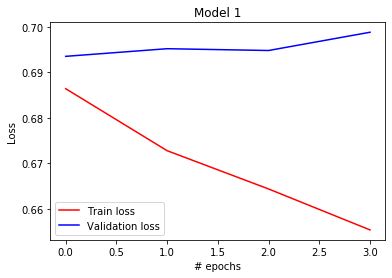

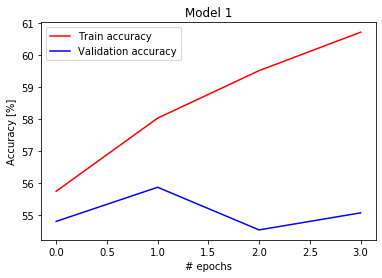

In [25]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots()
plt.title("Model 1")
fig2, ax2 = plt.subplots()
plt.title("Model 1")

ax1.plot(range(nEpochs), train_avg_losses_1, 'r-')
ax1.plot(range(nEpochs), val_avg_losses_1, 'b-')
ax1.legend(["Train loss", "Validation loss"])
ax1.set_xlabel("# epochs")
ax1.set_ylabel("Loss")

ax2.plot(range(nEpochs), train_accuracies_1, 'r-')
ax2.plot(range(nEpochs), val_accuracies_1, 'b-')
ax2.legend(["Train accuracy", "Validation accuracy"])
ax2.set_xlabel("# epochs")
ax2.set_ylabel("Accuracy [%]")

**(2 POE)** Based on these, what would you suggest for improving your model? Why?

**Your answer:** Training accuracy keeps increasing but validation accuracy stays around 55%. We suggest a deeper network to get more flexibility so the model can separate the classes better and hopefully we increase both training and validation accuracy. The validation loss seem to increase a bit also so we will add regularization to avoid overfitting.

---
## 3. Improving your model

**(1 POE)** Continue to improve your model architecture by comparing the value of the metrics you're interested in both the training and validation set. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here. Save the training and validation losses and accuracies. You'll use this later to compare your best model with the one using transfer learning.

**Note**: When trying different ideas, you'll end up with several different models. However, when submitting your solutions to Canvas, the cell below must contain only the definition and training of *one* model. Remove all code related to the models that were not chosen.

In [19]:
# YOUR CODE HERE
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 50, 3)
        self.conv2 = nn.Conv2d(50, 30, 3)
        self.fc1 = nn.Linear(23*23*30, 20, bias=True)
        self.fc2 = nn.Linear(20, 2, bias = True)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.fc1(x.view(125, 23*23*30)))
        x = self.fc2(x)
        return x

model_2 = Model_2()
model_2 = model_2.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_2.parameters(), lr=0.001, weight_decay=0.01) 

train_avg_losses_2 = []
train_accuracies_2 = []
val_avg_losses_2 = []
val_accuracies_2 = []

nEpochs = 6
for epoch in range(nEpochs):
    losses = []
    nCorrect = 0
    nTrainSamples = 0
    for b_x, b_y in dataloader_small_train:
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        
        # prediction and losses
        pred = model_2(b_x)
        pred = pred.to(device)
        
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        nCorrect += torch.sum(pred.argmax(dim=1) == b_y).item()
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        nTrainSamples += len(b_y)
        
    train_avg_loss = sum(losses)/len(losses)
    train_accuracy = (nCorrect / nTrainSamples)*100
    val_accuracy, val_avg_loss = evaluate_model(dataloader_small_val, model_2, loss_fn)   
    
    # For plotting
    train_avg_losses_2.append(train_avg_loss)
    train_accuracies_2.append(train_accuracy)
    val_avg_losses_2.append(val_avg_loss)
    val_accuracies_2.append(val_accuracy)
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} %'
    display_str += '\tAccuracy (val): {:.2f} %'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

Epoch 0 	Loss: 0.694 	Loss (val): 0.691	Accuracy: 51.14 %	Accuracy (val): 50.00 %
Epoch 1 	Loss: 0.671 	Loss (val): 0.661	Accuracy: 58.89 %	Accuracy (val): 61.67 %
Epoch 2 	Loss: 0.630 	Loss (val): 0.649	Accuracy: 64.31 %	Accuracy (val): 62.47 %
Epoch 3 	Loss: 0.594 	Loss (val): 0.612	Accuracy: 68.80 %	Accuracy (val): 68.60 %
Epoch 4 	Loss: 0.580 	Loss (val): 0.615	Accuracy: 69.51 %	Accuracy (val): 69.20 %
Epoch 5 	Loss: 0.558 	Loss (val): 0.626	Accuracy: 71.80 %	Accuracy (val): 68.67 %


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Text(0, 0.5, 'Accuracy [%]')

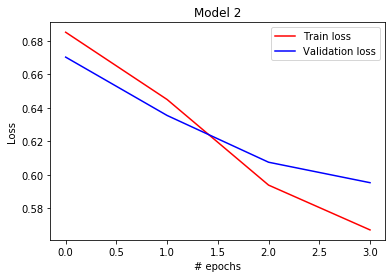

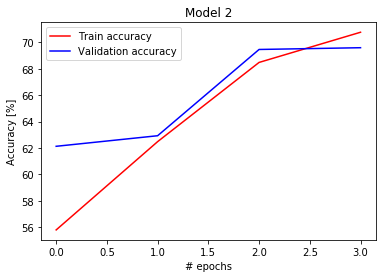

In [27]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots()
plt.title("Model 2")
fig2, ax2 = plt.subplots()
plt.title("Model 2")

ax1.plot(range(nEpochs), train_avg_losses_2, 'r-')
ax1.plot(range(nEpochs), val_avg_losses_2, 'b-')
ax1.legend(["Train loss", "Validation loss"])
ax1.set_xlabel("# epochs")
ax1.set_ylabel("Loss")

ax2.plot(range(nEpochs), train_accuracies_2, 'r-')
ax2.plot(range(nEpochs), val_accuracies_2, 'b-')
ax2.legend(["Train accuracy", "Validation accuracy"])
ax2.set_xlabel("# epochs")
ax2.set_ylabel("Accuracy [%]")

**(2 POE)** Did your results improve? What problems did your improvements fix? Explain why, or why not. 

**Your answer:** Validation loss did not increase, could be because we added regularisation. Accuracy increased, deeper network makes it possible to model more complex features and simply fit better to the data.

[Save your model](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to disk (the architecture, weights and optimizer state). This is simply so you can use it again easily in the later parts of the notebook, without having to keep it in memory or re-training it. The actual file you create is not relevant to your submission. The code to save the model is given in the cell below. 

In [28]:
# Assuming that you called your model 'model'
import copy
torch.save(model_2.state_dict(), 'my_model')

---
## 4. Transfer Learning

Now, instead of trying to come up with a good architecture for this task, we'll use the VGG16 architecture, but with the top layers removed (the fully connected layers + softmax). We'll substitute them with a single fully connected layer, and a classification layer that makes sense for our problem.

However, this model has a very high capacity, and will probably suffer a lot from overfitting if we try to train it from scratch, using only our small subset of data. Instead, we'll start the optimization with the weights obtained after training VGG16 on the ImageNet dataset.

Start by loading the *pretrained* VGG16 model, from the [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html).

In [17]:
# YOUR CODE HERE
vgg16 = models.vgg16(pretrained=True)

# Need to increase the image size
IMAGE_SIZE = 224

transform = transforms.Compose([
    transforms.Resize(size = (IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

dataset_small_train = datasets.ImageFolder(small_train_path, transform=transform)
dataset_small_val = datasets.ImageFolder(small_val_path, transform=transform) 

BATCH_SIZE = 32
dataloader_small_train = DataLoader(dataset_small_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
dataloader_small_val = DataLoader(dataset_small_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Create a new model with the layers you want to add on top of VGG.

*Hint:*
- You can access the top layers of the VGG model with `vgg_model.classifier`, and the remaining layers with `vgg_model.features`.
- You can get the number of output features of `vgg_model.features` with `vgg_model.classifier[0].in_features`

In [18]:
# YOUR CODE HERE
class vggTopLayerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(25088, 1)
    
    def forward(self, x):
        x = self.fc(x)
        return x
vggTopLayer = vggTopLayerModel()

Now add the new model on top of VGG.

In [19]:
# YOUR CODE HERE
vgg16.classifier = vggTopLayer

### 4.1 Using VGG features

Now we're almost ready to train the new model. However, since the top layers of this architecture are being initialized randomly, it's sometimes possible for them to generate large gradients that can wreck the pretraining of the bottom layers. To avoid this, freeze all the VGG layers in your architecture (i.e. signal to the optimizer that these should not be changed during optimization) by setting the attribute `requires_grad` for all parameters `vgg_model.features` to `False`.

In [20]:
# Freeze bottom
# YOUR CODE HERE
for param in vgg16.features.parameters():
    param.requires_grad = False

Perform the transfer learning by training the top layers of your model.

In [23]:
# YOUR CODE HERE
def evaluate_model2(data, model, loss_fn):
    losses = []
    nCorrect = 0
    nValSamples = 0
    for b_x, b_y in data:
        pred = model(b_x.to(device))
        b_y = b_y.type(torch.FloatTensor).view(b_y.shape[0],1)
        b_y = b_y.to(device)
        
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        sig = nn.Sigmoid()
        sigInput = pred.view(b_y.shape[0])
        sigOutput = sig(sigInput)
        sigOutput = sigOutput.round().type(torch.LongTensor)
        
        nCorrect += torch.sum(sigOutput.view(b_y.shape[0],1).to(device) == b_y.type(torch.LongTensor).to(device)).item()
        nValSamples += len(b_y)
        
    val_accuracy = (nCorrect / nValSamples)*100
    val_avg_loss = sum(losses)/len(losses)
    return val_accuracy, val_avg_loss

device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
vgg16.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)

train_avg_losses_3 = []
train_accuracies_3 = []
val_avg_losses_3 = []
val_accuracies_3 = []

nEpochs = 4
for epoch in range(nEpochs):
    losses = []
    nCorrect = 0
    nTrainSamples = 0
    for b_x, b_y in dataloader_small_train:
        # prediction and losses
        pred = vgg16(b_x.to(device))
        
        b_y = b_y.type(torch.FloatTensor).view(b_y.shape[0],1)
        b_y = b_y.to(device)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        sig = nn.Sigmoid()
        sigInput = pred.view(b_y.shape[0])
        sigOutput = sig(sigInput)
        sigOutput = sigOutput.round().type(torch.LongTensor)
        
        nCorrect += torch.sum(sigOutput.view(b_y.shape[0],1).to(device) == b_y.type(torch.LongTensor).to(device)).item()
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        nTrainSamples += len(b_y)
        
    train_avg_loss = sum(losses)/len(losses)
    train_accuracy = (nCorrect / nTrainSamples)*100
    val_accuracy, val_avg_loss = evaluate_model2(dataloader_small_val, vgg16, loss_fn)
    
    # For plotting
    train_avg_losses_3.append(train_avg_loss)
    train_accuracies_3.append(train_accuracy)
    val_avg_losses_3.append(val_avg_loss)
    val_accuracies_3.append(val_accuracy)
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} %'
    display_str += '\tAccuracy (val): {:.2f} %'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

Epoch 0 	Loss: 0.042 	Loss (val): 0.157	Accuracy: 98.60 %	Accuracy (val): 95.40 %
Epoch 1 	Loss: 0.013 	Loss (val): 0.151	Accuracy: 99.69 %	Accuracy (val): 96.07 %
Epoch 2 	Loss: 0.003 	Loss (val): 0.138	Accuracy: 99.97 %	Accuracy (val): 96.33 %
Epoch 3 	Loss: 0.005 	Loss (val): 0.141	Accuracy: 99.94 %	Accuracy (val): 96.07 %


Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Text(0, 0.5, 'Accuracy [%]')

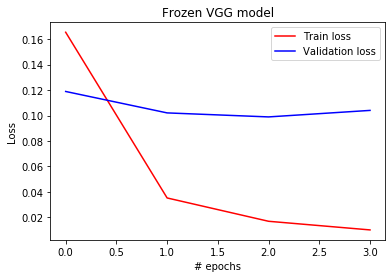

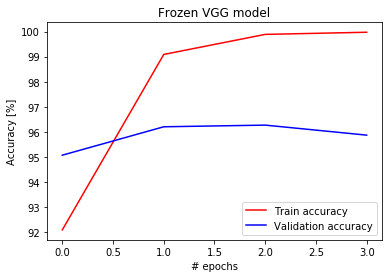

In [10]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots()
plt.title("Frozen VGG model")
fig2, ax2 = plt.subplots()
plt.title("Frozen VGG model")

ax1.plot(range(nEpochs), train_avg_losses_3, 'r-')
ax1.plot(range(nEpochs), val_avg_losses_3, 'b-')
ax1.legend(["Train loss", "Validation loss"])
ax1.set_xlabel("# epochs")
ax1.set_ylabel("Loss")

ax2.plot(range(nEpochs), train_accuracies_3, 'r-')
ax2.plot(range(nEpochs), val_accuracies_3, 'b-')
ax2.legend(["Train accuracy", "Validation accuracy"])
ax2.set_xlabel("# epochs")
ax2.set_ylabel("Accuracy [%]")

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

Text(0, 0.5, 'Accuracy [%]')

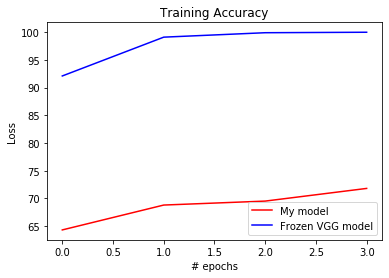

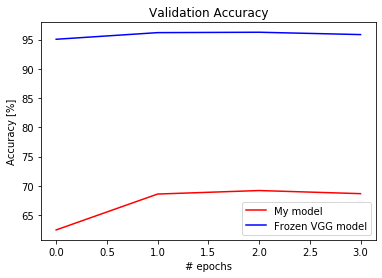

In [26]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots()
plt.title("Training Accuracy")
fig2, ax2 = plt.subplots()
plt.title("Validation Accuracy")

ax1.plot(range(nEpochs), train_accuracies_2[2:], 'r-')
ax1.plot(range(nEpochs), train_accuracies_3, 'b-')
ax1.legend(["My model", "Frozen VGG model"])
ax1.set_xlabel("# epochs")
ax1.set_ylabel("Loss")

ax2.plot(range(nEpochs), val_accuracies_2[2:], 'r-')
ax2.plot(range(nEpochs), val_accuracies_3, 'b-')
ax2.legend(["My model", "Frozen VGG model"])
ax2.set_xlabel("# epochs")
ax2.set_ylabel("Accuracy [%]")

**(1 POE)** Compare these results. Which approach worked best, starting from scratch or doing transfer learning? Explain how you evaluated this.

**Your answer:** The transfer learning worked best since it got much better accuracy. This is probably the case beacuse of the vgg net is already trained and the fact that is a much deeper network than the one we made from scratch. So it is not really fair to compare these models in this way since the other one is a lot deeper.

**(1 POE)** What are the main differences between the ImageNet dataset and the Dogs vs Cats dataset we used?

**Your answer:** ImageNet has more classes and Dogs vs Cats has only two. Also the amount of data is less for Dogs vs Cats.

**Optional (2 POE)** Even though there are considerable differences between these datasets, why is it that transfer learning is still a good idea?

**Your answer:** It has been shown that first training a network for similar tasks or similar data compare to what you intend to use the network for, and then tune it specifically for your specific task or data, can increase the performance.

**Optional (1 POE)** In which scenario would transfer learning be unsuitable?

**Your answer:** If the tasks or data are not similar.

Save the model to a file.

In [10]:
torch.save(vgg16.state_dict(), 'trans_learning_top_only')

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom layers by resetting the `requires_grad` attribute to `True`.

In [24]:
# UnFreeze bottom
# YOUR CODE HERE
for param in vgg16.features.parameters():
    param.requires_grad = True

Fine tune the model by training all the layers.

Hint:
- Even though we do have a decent starting point for the optimization, it's still possible that a bad hyper-parameter choice wrecks the preinitialization. Make sure to use a small learning rate for this step.

In [25]:
# YOUR CODE HERE

def evaluate_model2(data, model, loss_fn):
    losses = []
    nCorrect = 0
    nValSamples = 0
    for b_x, b_y in data:
        pred = model(b_x.to(device))
        b_y = b_y.type(torch.FloatTensor).view(b_y.shape[0],1)
        b_y = b_y.to(device)
        
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        sig = nn.Sigmoid()
        sigInput = pred.view(b_y.shape[0])
        sigOutput = sig(sigInput)
        sigOutput = sigOutput.round().type(torch.LongTensor)
        
        nCorrect += torch.sum(sigOutput.view(b_y.shape[0],1).to(device) == b_y.type(torch.LongTensor).to(device)).item()
        nValSamples += len(b_y)
        
    val_accuracy = (nCorrect / nValSamples)*100
    val_avg_loss = sum(losses)/len(losses)
    return val_accuracy, val_avg_loss


device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

vgg16.to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

train_avg_losses_4 = []
train_accuracies_4 = []
val_avg_losses_4 = []
val_accuracies_4 = []

nEpochs = 3
for epoch in range(nEpochs):
    losses = []
    nCorrect = 0
    nTrainSamples = 0
    for b_x, b_y in dataloader_small_train:
        # prediction and losses
        pred = vgg16(b_x.to(device))
        
        b_y = b_y.type(torch.FloatTensor).view(b_y.shape[0],1)
        b_y = b_y.to(device)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        sig = nn.Sigmoid()
        sigInput = pred.view(b_y.shape[0])
        sigOutput = sig(sigInput)
        sigOutput = sigOutput.round().type(torch.LongTensor)
        
        nCorrect += torch.sum(sigOutput.view(b_y.shape[0],1).to(device) == b_y.type(torch.LongTensor).to(device)).item()
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        nTrainSamples += len(b_y)
        
    train_avg_loss = sum(losses)/len(losses)
    train_accuracy = (nCorrect / nTrainSamples)*100
    
    val_accuracy, val_avg_loss = evaluate_model2(dataloader_small_val, vgg16, loss_fn)
    
    # For plotting
    train_avg_losses_4.append(train_avg_loss)
    train_accuracies_4.append(train_accuracy)
    val_avg_losses_4.append(val_avg_loss)
    val_accuracies_4.append(val_accuracy)
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} %'
    display_str += '\tAccuracy (val): {:.2f} %'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

Epoch 0 	Loss: 0.136 	Loss (val): 0.107	Accuracy: 96.14 %	Accuracy (val): 97.53 %
Epoch 1 	Loss: 0.009 	Loss (val): 0.092	Accuracy: 99.74 %	Accuracy (val): 97.60 %
Epoch 2 	Loss: 0.004 	Loss (val): 0.106	Accuracy: 99.91 %	Accuracy (val): 98.13 %


How does the model perform, compared to the model trained with freezed layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

Text(0, 0.5, 'Accuracy [%]')

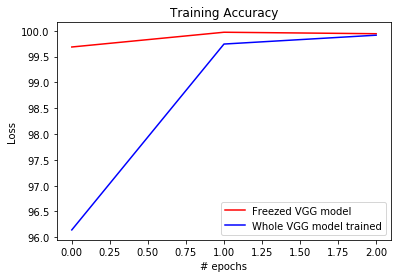

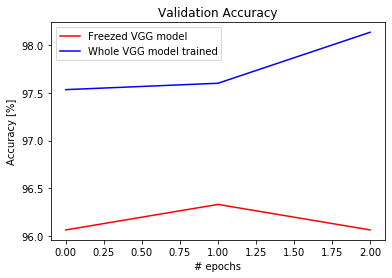

In [26]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots()
plt.title("Training Accuracy")
fig2, ax2 = plt.subplots()
plt.title("Validation Accuracy")

ax1.plot(range(nEpochs), train_accuracies_3[1:], 'r-')
ax1.plot(range(nEpochs), train_accuracies_4, 'b-')
ax1.legend(["Freezed VGG model", "Whole VGG model trained"])
ax1.set_xlabel("# epochs")
ax1.set_ylabel("Loss")

ax2.plot(range(nEpochs), val_accuracies_3[1:], 'r-')
ax2.plot(range(nEpochs), val_accuracies_4, 'b-')
ax2.legend(["Freezed VGG model", "Whole VGG model trained"])
ax2.set_xlabel("# epochs")
ax2.set_ylabel("Accuracy [%]")

**(1 POE)** Did the model's performance improve? Why (why not)?

**Your answer:** The validation accuracy increased since the layers that has been trained for all classes in ImageNet was trained for only cats and dogs now. The parameters could be updated to better fit our data. 

Save the model to file.

In [54]:
torch.save(vgg16.state_dict(), 'trans_learning_full')

### 4.3 Improving the top model (optional)

Improve the architecture for the layers you add on top of VGG16. Try different ideas! When you're happy with one architecture, copy it in the cell below and train it here.

In [ ]:
# YOUR CODE HERE

**(1 POE)** How does the model perform, compared to the model trained in step 4.2? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE

Save the model to a file.

In [ ]:
torch.save(model.state_dict(), 'best_trans_learning')

## 5. Final training

Now we'll train the model that achieved the best performance so far using the entire dataset.

**Note**: start the optimization with the weights you obtained training in the smaller subset, i.e. *not* from scratch.

First, create two new data generators, one for training samples and one for validation samples. This time, they'll load data from the folders for the entire dataset.

In [27]:
# YOUR CODE HERE
IMAGE_SIZE = 224

transform = transforms.Compose([
    transforms.Resize(size = (IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder(train_path, transform=transform)
dataset_val = datasets.ImageFolder(val_path, transform=transform) 

BATCH_SIZE = 32
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True,num_workers=4)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

Train your model using the full data. This optimization might take a long time, so live plotting of some metrics is recommended.

In [29]:
# YOUR CODE HERE

loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)

train_avg_losses_5 = []
train_accuracies_5 = []
val_avg_losses_5 = []
val_accuracies_5 = []

nEpochs = 3
for epoch in range(nEpochs):
    losses = []
    nCorrect = 0
    nTrainSamples = 0
    for b_x, b_y in dataloader_train:
        # prediction and losses
        pred = vgg16(b_x.to(device))
        
        b_y = b_y.type(torch.FloatTensor).view(b_y.shape[0],1)
        b_y = b_y.to(device)
        loss = loss_fn(pred, b_y)
        losses.append(loss.item())
        
        sig = nn.Sigmoid()
        sigInput = pred.view(b_y.shape[0])
        sigOutput = sig(sigInput)
        sigOutput = sigOutput.round().type(torch.LongTensor)
        
        nCorrect += torch.sum(sigOutput.view(b_y.shape[0],1).to(device) == b_y.type(torch.LongTensor).to(device)).item()
        
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        nTrainSamples += len(b_y)
        
    train_avg_loss = sum(losses)/len(losses)
    train_accuracy = (nCorrect / nTrainSamples)*100
    val_accuracy, val_avg_loss = evaluate_model2(dataloader_val, vgg16, loss_fn)
    
    # For plotting
    train_avg_losses_5.append(train_avg_loss)
    train_accuracies_5.append(train_accuracy)
    val_avg_losses_5.append(val_avg_loss)
    val_accuracies_5.append(val_accuracy)
    
    # Display metrics
    display_str = 'Epoch {} '
    display_str += '\tLoss: {:.3f} '
    display_str += '\tLoss (val): {:.3f}'
    display_str += '\tAccuracy: {:.2f} %'
    display_str += '\tAccuracy (val): {:.2f} %'
    print(display_str.format(epoch, train_avg_loss, val_avg_loss, train_accuracy, val_accuracy))

torch.save(vgg16.state_dict(), 'final_trans_learning')

Epoch 0 	Loss: 0.065 	Loss (val): 0.037	Accuracy: 97.67 %	Accuracy (val): 98.36 %
Epoch 1 	Loss: 0.032 	Loss (val): 0.040	Accuracy: 98.86 %	Accuracy (val): 98.44 %
Epoch 2 	Loss: 0.029 	Loss (val): 0.087	Accuracy: 98.97 %	Accuracy (val): 97.64 %


How does the model perform now when trained on the entire dataset, compared to when only trained on the smaller subset of data? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

Text(0, 0.5, 'Accuracy [%]')

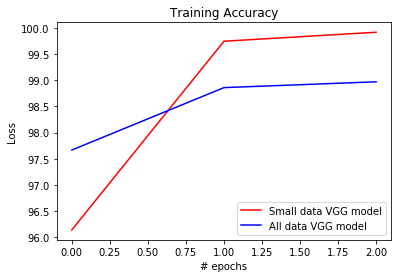

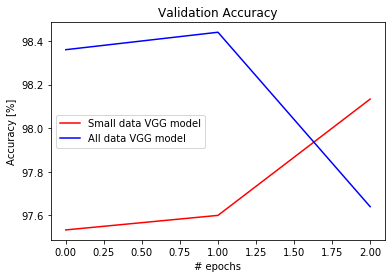

In [30]:
# YOUR CODE HERE
fig1, ax1 = plt.subplots()
plt.title("Training Accuracy")
fig2, ax2 = plt.subplots()
plt.title("Validation Accuracy")

ax1.plot(range(nEpochs), train_accuracies_4, 'r-')
ax1.plot(range(nEpochs), train_accuracies_5, 'b-')
ax1.legend(["Small data VGG model", "All data VGG model"])
ax1.set_xlabel("# epochs")
ax1.set_ylabel("Loss")

ax2.plot(range(nEpochs), val_accuracies_4, 'r-')
ax2.plot(range(nEpochs), val_accuracies_5, 'b-')
ax2.legend(["Small data VGG model", "All data VGG model"])
ax2.set_xlabel("# epochs")
ax2.set_ylabel("Accuracy [%]")

**(2 POE)** What can you conclude from these plots?

**Your answer:** The model had better fit on the smaller data, which is not surprising. We were able to get better validation accuracy when training on all data, at least for the two first epochs. This is reasonable since more training data usually makes the model to generalize better and lowers the risk to model noise in the training data. 

## 6. Evaluation on test set

Now we'll evaluate your final model, obtained in step 6, on the test set. As mentioned before, the samples in the test set are not labeled, so we can't compute any performance metrics ourselves. Instead, we'll create a .csv file containing the predictions for each sample, and submit it to Kaggle for evaluation.

Compute the predictions for all samples in the test set according to your best model, and save it in a .csv file with the format expected by the competition.

Hints:
- There is a sample_submission file available for download in the same place where you downloaded the data from. Take a look at it to better understand what is the expected format here.
- The Python module `os` has a `listdir` function, which returns the filenames of all files in a given path.
- If you don't know how to create and write to files with Python, Google can help.

In [54]:
# YOUR CODE HERE
import csv
from PIL import Image
import glob


sig = nn.Sigmoid()
predictions = []
IDs = []

trans = transforms.ToTensor()
trans1 = transforms.Resize(size = (224,224))

for filename in glob.glob('test1/*.jpg'):
    ID = filename[6:(len(filename)-4)]
    IDs.append(ID)
    im=Image.open(filename)
    im = trans1(im)
    im = trans(im)

    pred = vgg16(im.view(1,3,224,224).to(device))
    sigOutput = sig(pred)
    sigOutput = sigOutput.round().type(torch.LongTensor)
    predictions.append(sigOutput)

with open('submission.csv', mode='w') as file:
        file_writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        file_writer.writerow(['id', 'label'])
        for i in range(len(predictions)):
            file_writer.writerow([IDs[i], predictions[i].item()])

**(2 POE)** Now that you created your submission file, submit it to Kaggle for evaluation. The [old competition](https://www.kaggle.com/c/dogs-vs-cats) does not allow submissions any more, so submit your file to the [new one](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). Kaggle evaluates your submission according to your log-loss score. Which score did you obtain?

**Your answer:** 0.92565

What was the username you used for this submission?

**Your answer:** toobbekarlsson